In [15]:
# Parameters to set

# File
filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2"
offset = 513843715
num_files = 6
traces_per_file = 2

# Analysis

# Found by verifying where the noise cumulative VPSD reaches 4% of signal cumulative VPSD
bin_num = 42
# (V^2/m^2) Found by fitting to PSD
V = 68.598e14
# (Hz) Found where low f noise begins to dominate in the PSD
high_pass = 100


In [16]:
import csv
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
import os
from nptdms import TdmsFile

def save_results_to_csv(traces, output_file):

    trace_headers = [f"Trace {i + 1}" for i in range(len(traces))]

    # Write data to CSV
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer.writerow(trace_headers)

        max_trace_length = max(len(trace) for trace in traces)

        for i in range(max_trace_length):
            row = []
            for trace in traces:
                if i < len(trace):
                    row.append(trace[i])
                else:
                    row.append("")
            writer.writerow(row)

    print(f"Data saved to {output_file}")

In [17]:
def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }

def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args


In [18]:
# Load the File
results = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
print(results[0]["args"])

Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 0
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 1
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 2
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 3
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 4
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\smaller_aligned2 5
data_col  X
{'sampling_rate': 25000000.0, 'track_len': 4194304}


In [19]:
# Bin the data and set the time trace x axis

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in results:
    series = bin_data(trace["series"], bin_num)
    traces.append(series)

time = np.arange(0, len(traces[0]))
time = time * (bin_num/(results[0]['args']['sampling_rate']))
fs = results[0]['args']['sampling_rate']/bin_num


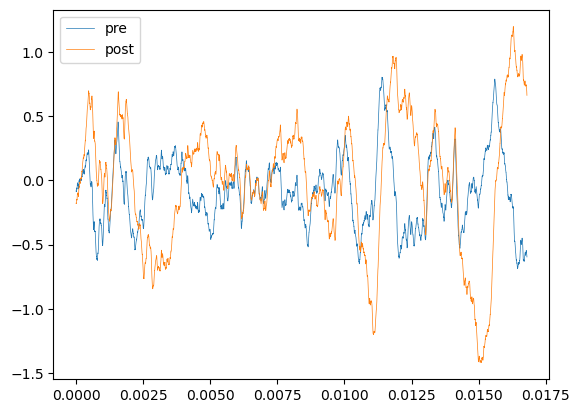

In [20]:
# Apply the transfer function

# To account for near zero DC transfer we apply tikhonov regularization. We find alpha to be the frequency in which noise (low f) begins to dominate (around 100Hz)

# We will appky the following to the signal S:   U = S/T    -->  U = S*T/(T^2 + L^2)      where U is the underlying signal, S is the raw signal, T is the transfer function and L is some paramter lambda

def transfer_func(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    A = 4000
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + (1/3)*(A)**2)
    RC_high_pass = x_c / (x_c+C)
    return Sallen_key*RC_high_pass

# This number (100Hz) was found by visually inspecting the PSD, observing where the low f noise takes over (100Hz), and choosing lamda to be the magnitude of the transfer function at 100Hz so that the lamda term begins to take over when f > 100 Hz
lda = np.abs(transfer_func(high_pass))

traces_post_transfer = []

for trace in traces:
    # apply the transfer and convert back
    freq_domain_data = scipy.fft.fft(trace)
    frequencies = scipy.fft.fftfreq(len(trace), time[1] - time[0])
    transfer = transfer_func(frequencies)

    freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
    data = np.fft.ifft(freq_domain_data_transfer)

    traces_post_transfer.append(np.real(data))


plt.plot(time[:10000], traces[0][:10000], label = "pre", linewidth=.5)
plt.plot(time[:10000], traces_post_transfer[0][:10000], label = "post", linewidth=.5)
plt.legend()
plt.show()

# Visualize transfer functions

# frequencies1 = scipy.fft.fftfreq(len(traces[0]), time[1] - time[0])
# transfer1 = transfer_func(frequencies1)
#
# plt.plot(frequencies1, np.abs(transfer1), ".", label="Transfer Function", linewidth=.5)
# plt.plot(frequencies1, np.abs((np.real(transfer1)**2 + np.imag(transfer1)**2 + lda**2)/np.conj(transfer1)), ".", label="Effective Transfer Function", linewidth=.5)
# plt.ylim(bottom=1e-8)
# plt.xscale("log")
# plt.yscale("log")
# plt.axvline(x = 100, color = "r", linestyle = "--")
# plt.legend()
# plt.show()

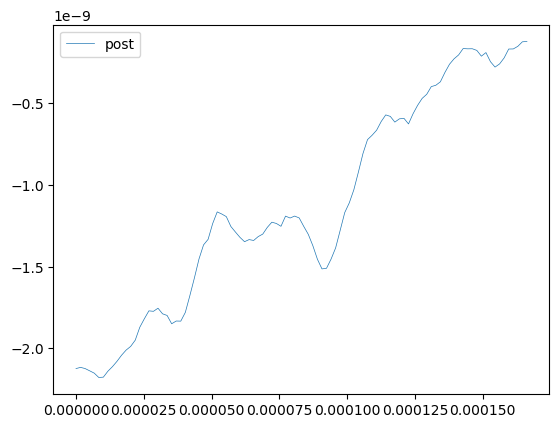

In [21]:
# Convert volts to meters
# This factor was found by fitting to the PSD

v_squared = V
v = math.sqrt(v_squared)

traces_post_meter = []
for trace in traces_post_transfer:
    traces_post_meter.append(np.real(trace / v))

# plt.plot(time[:10000], traces_post_transfer[0][:10000], label = "pre", linewidth=.5)
plt.plot(time[:100], traces_post_meter[0][:100], label = "post", linewidth=.5)
plt.legend()
plt.show()

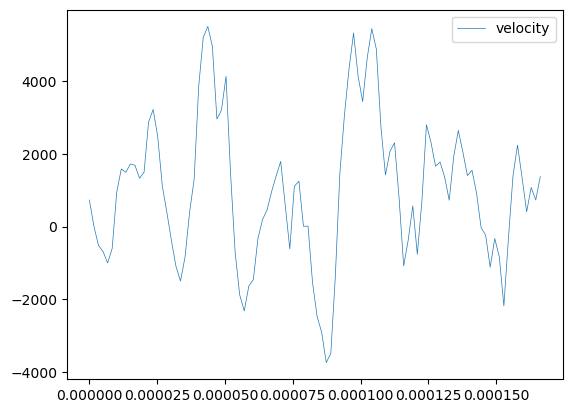

In [22]:
# Apply second order finite differences to find velocity traces

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

velocity_traces = []
for trace in traces_post_transfer:
    velocity = get_velocity_higher_order(trace, time, 2)
    velocity_traces.append(velocity)

plt.plot(time[:100], velocity_traces[0][:100], label = "velocity", linewidth=.5)
plt.legend()
plt.show()

In [23]:
# We now want to save off three files
# The voltage to meter converted position and velocity trace, and the non voltage to meter converted position traces

filenames_and_data = {"barium_titanate_in_acetone_voltages": traces_post_transfer,
                      "barium_titanate_in_acetone_position": traces_post_meter,
                      "barium_titanate_in_acetone_velocity": velocity_traces}

for filename in filenames_and_data:
    output_path = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\"
    output_file = f"{filename}.csv"
    file_path = output_path + output_file

    save_results_to_csv(filenames_and_data[filename], file_path)
    print(f"Data saved to {file_path}")

Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_voltages.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_voltages.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_position.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_position.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_velocity.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\PROCESSED_DATA\\barium_titanate_in_acetone_velocity.csv


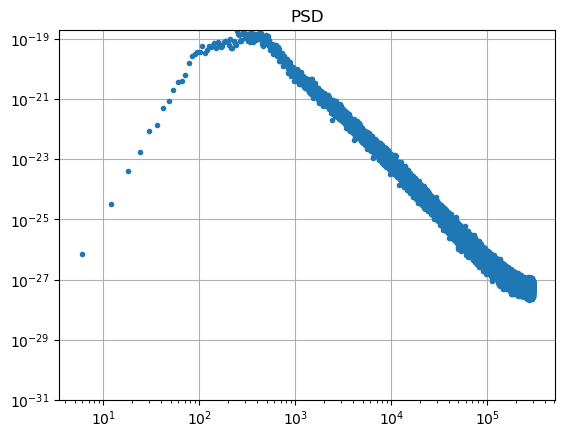

In [24]:
# Check our PSD
psds = []
frequency = 0
for trace in traces_post_meter:
    frequency, psd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    psds.append(psd)
plt.plot(frequency, np.mean(psds, axis=0), ".")
plt.ylim(bottom=1e-31)
# plt.xlim(left=1e4)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("PSD")
plt.show()

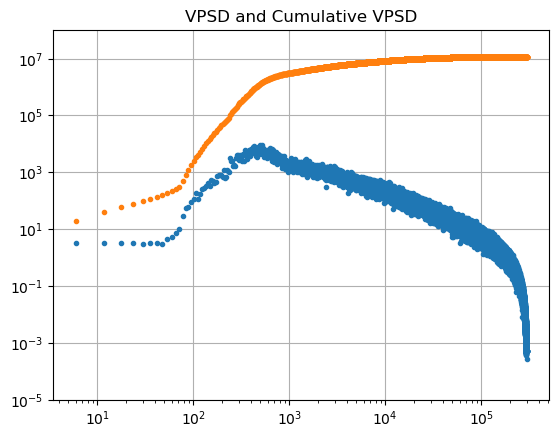

In [25]:
# Check our VPSD
vpsds = []
frequency = 0
for trace in velocity_traces:
    frequency, vpsd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    vpsds.append(vpsd)
vpsd = np.mean(vpsds, axis=0)
plt.plot(frequency, vpsd, ".")
cumulative_vpsd = np.cumsum(vpsd) * (frequency[1] - frequency[0])  # assuming uniform frequency spacing
plt.plot(frequency, cumulative_vpsd, ".")
plt.ylim(bottom=1e-5)
plt.ylim(top=1e8)
plt.xscale('log')
plt.yscale('log')
plt.title("VPSD and Cumulative VPSD")
plt.grid()
plt.show()

In [ ]:
from tqdm import tqdm
def compute_VACF_time_domain(v_series):
    n = len(v_series)
    vacf = np.zeros(n)
    for lag in tqdm(range(n), desc="VACF Compute"):
        vacf[lag] = np.dot(v_series[:n - lag], v_series[lag:]) / (
                n - lag)  # Normalize by number of overlapping terms
    return vacf

all_vacf = []

for series in traces_post_meter:
    v_series = np.diff(series) / np.diff(time)
    vacf = compute_VACF_time_domain(v_series)
    all_vacf.append(vacf)

VACF Compute:  12%|█▏        | 12113/99863 [00:01<00:11, 7964.36it/s]

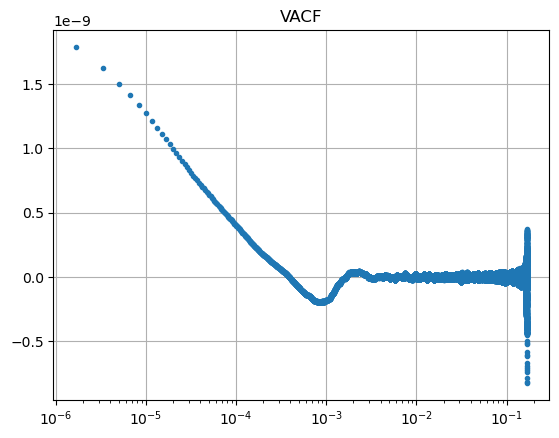

In [12]:
avg_vacf = np.mean(all_vacf, axis=0)

plt.plot(time[1:], avg_vacf, ".")
plt.xscale('log')
plt.title("VACF")
plt.grid()

100%|██████████| 99864/99864 [00:07<00:00, 14179.08it/s]


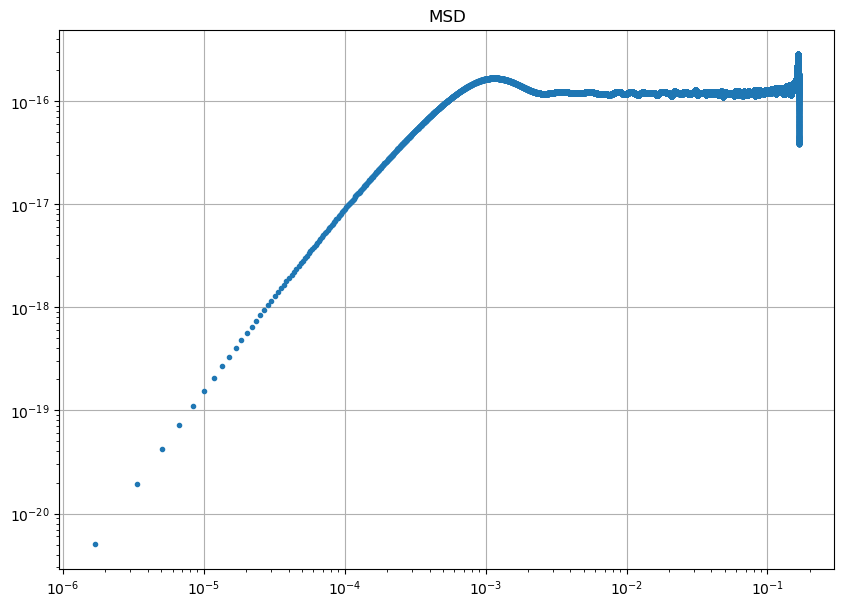

In [13]:
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

all_hp_msd = []
lag_times = 0
for series in traces_post_meter:
    msd, lag_times = compute_msd(series, 1/fs)
    all_hp_msd.append(msd)

hp_avg_msd = np.mean(all_hp_msd, axis=0)
plt.figure(figsize=(10, 7))
plt.plot(lag_times, hp_avg_msd, ".", label='HP Average MSD')
plt.xscale("log")
plt.yscale("log")

plt.title("MSD")
plt.grid(True)

In [14]:
# #OLD
#
# def get_transfer(freq):
#     df = pd.read_csv(r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\no_filter_response.txt")
#     freqs = np.array(df[df.keys()[0]])
#     r = np.array(df[df.keys()[1]])
#     # Debug: Check for zeros in r
#     if np.any(r == 0):
#         print("Warning: Interpolation data contains zeros in the response column.")
#
#     interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")
#
#     def low_freq_fit(x):
#         A, B =   -306.24611144, 184968.79274103
#         C = 1 / (2*np.pi*10**-6*1000)
#         Sallen_key = x**2 / (x**2 + A*x + B)
#         RC_high_pass = x / (x +C )
#         result = (Sallen_key * RC_high_pass) ** 2
#
#         # Debug: Check for zeros in the low_freq_fit output
#         if np.any(result == 0):
#             print(f"Warning: low_freq_fit returned zero for input x = {x}")
#         return result
#     print(interpolation(freq))
#     return np.where(freq < 10**5, np.sqrt(low_freq_fit(freq)), 1) #np.sqrt(interpolation(freq)))
#
#
# frequencies1 = scipy.fft.fftfreq(len(traces[0]), time[1] - time[0])
# transfer1 = get_transfer(frequencies1)
# plt.plot(frequencies1, transfer1, ".", label="Transfer Function", linewidth=.5)
# # plt.plot( ((np.real(transfer1)**2 + np.imag(transfer1)**2 + lda**2)/ transfer1), ".", label="Effective Transfer Function", linewidth=.5)
# plt.ylim(bottom=1e-8)
# plt.xscale("log")
# plt.yscale("log")
# plt.axvline(x = 100, color = "r", linestyle = "--")
# plt.legend()
# plt.show()